# InputDSA tutorial (Huang and Ostrow 2025 Fig. 2). InputDSA accurately distinguishes partially observed, input-driven dynamical systems

In this analysis, we are going to look at how to appropriately compare partially observed systems

we will look at 4 different dynamical systems, made up of 2 pairings: 
1. (1,2), (3,4) have the same intrinsic dynamics
2. (1,3) (2,4) have the same read in dynamics -- how the input affects the state

We will compare different types of DMDs (and therefore DSAs): 
1. Dynamic Mode Decomposition (DMD) with delay embeddings (Hankel DMD / Havok). This method must ignore the input
2. DMD with control (DMDc, Proctor et al., 2016). This method does joint regression on the state and the input to learn an input and a state dynamics operator. However, it assumes full observation of the state, and if not, naive application of delay embeddings to resolve partial observations result in intrinsic dynamics leakage into the input operator (Fig 2a). 
3. Subspace DMDc (N4SID on lifted states, Huang and Ostrow 2025). This method uses subspace identification methods to appropriately separate the effect of input and state on delay embedded data


In [1]:
"""
Figure 2 InputDSA Data Analysis 
"""
%load_ext autoreload
%autoreload 2

n = 20          # latent state dim
n_large = 50
m = 1           # input dim  
p_out = 10      # observed dim (partial observation) - gets overridden in some cells
p_out_small = 2
N = 10000        # sequence length
N_small = 1000
n_Us = 4
obs_noise = 0.01
process_noise = 0.0
nonlinear_eps = 0.1
input_alpha = 0.001
g1 = 0.5
g2 = 2.0
rho1 = 0.92
rho2 = 0.82
seed1 = 11
seed2 = 12
n_delays = 150
rank = 20
pf = 150
n_iters = 10
backend = 'n4sid'

print(f"Shared parameters:")
print(f"  System: n={n}, m={m}, p_out={p_out}, N={N}")
print(f"  Dynamics: rho1={rho1}, rho2={rho2}, g1={g1}, g2={g2}")
print(f"  Noise: obs_noise={obs_noise}, process_noise={process_noise}")
print(f"  Nonlinearity: nonlinear_eps={nonlinear_eps}")
print(f"  Model: n_delays={n_delays}, rank={rank}, pf={pf}")
print(f"  Evaluation: n_iters={n_iters}")


Shared parameters:
  System: n=20, m=1, p_out=10, N=10000
  Dynamics: rho1=0.92, rho2=0.82, g1=0.5, g2=2.0
  Noise: obs_noise=0.01, process_noise=0.0
  Nonlinearity: nonlinear_eps=0.1
  Model: n_delays=150, rank=20, pf=150
  Evaluation: n_iters=10


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Updated to use DSA package imports
import sys
sys.path.insert(0, '..')  # Add parent directory to path to import DSA

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [3]:
from DSA import InputDSA
from DSA import SimilarityTransformDist as SimDist
from DSA import ControllabilitySimilarityTransformDist as ControlSimDist
from tqdm import tqdm

def compare_systems_with_InputDSA(Ys, Us, n_delays=150, rank=10, backend='n4sid'):
    """
    Compare controlled systems using InputDSA from DSA package.
    Uses the new update_compare_method() to avoid refitting DMDs multiple times.
    
    Parameters:
    - Ys: list of output data arrays (p_out, N)
    - Us: list of control input arrays (m, N)
    - n_delays: number of delays for DMD
    - rank: rank for DMD
    - backend: 'n4sid' or 'custom' for SubspaceDMDc
    
    Returns:
    - sims_full: joint similarity scores
    - sims_control_joint: control scores from joint optimization
    - sims_state_joint: state scores from joint optimization
    - sims_control_separate: control scores from separate optimization
    - sims_state_separate: state scores from separate optimization
    """
    # Transpose data for InputDSA (expects time_first=True by default)
    Ys_T = [Y.T for Y in Ys]
    Us_T = [U.T for U in Us]
    
    # Configure DMD
    # dmd_config = SubspaceDMDcConfig(
        # n_delays=n_delays,
        # rank=rank,
        # backend=backend
    # )
    dmd_config = dict(
        n_delays=n_delays,
        rank=rank,
        backend=backend
    )
    
    # Create InputDSA with joint comparison
    # This will fit the DMDs once and return joint comparison results
    inputDSA = InputDSA(
        X=Ys_T,
        X_control=Us_T,
        dmd_config=dmd_config,
        compare='joint',
        return_distance_components=True
    )
    
    # Fit DMDs and get joint comparison results
    sims_full, sims_state_joint, sims_control_joint = inputDSA.fit_score()
    
    # Update comparison method to 'state' without refitting DMDs
    inputDSA.update_compare_method(compare='state')
    sims_state_separate = inputDSA.score()
    
    # Update comparison method to 'control' without refitting DMDs
    inputDSA.update_compare_method(compare='control')
    sims_control_separate = inputDSA.score()
    
    return sims_full, sims_control_joint, sims_state_joint, sims_control_separate, sims_state_separate


#strict comparison metrics, for when we fit and compare separately
def compare_A(A1,A2):
    simdist = SimDist(iters=1000,score_method='wasserstein',lr=1e-3,verbose=True)
    return simdist.fit_score(A1,A2)

def compare_A_full(As):
    sims = np.zeros((len(As),len(As)))
    for i in range(len(As)):
        for j in range(i+1,len(As)):
            sims[i,j] = compare_A(As[i],As[j])
            sims[j,i] = sims[i,j]
    return sims

def compare_B(B1,B2):
    csimdist = ControlSimDist(score_method='euclidean',compare='control')
    sim = csimdist.fit_score(None, None, B1, B2)
    return sim

def compare_systems_full(As,Bs):
    csimdist = ControlSimDist(score_method='euclidean',compare='joint',return_distance_components=True)
    sims_full = np.zeros((len(As),len(As)))
    sims_control_joint = np.zeros((len(As),len(As)))
    sims_state_joint = np.zeros((len(As),len(As)))
    sims_control_separate = np.zeros((len(As),len(As)))
    sims_state_separate = np.zeros((len(As),len(As)))
    for i in tqdm(range(len(As))):
        for j in range(i+1,len(As)):
            all_sims = csimdist.fit_score(As[i],As[j],Bs[i],Bs[j])
            sims_full[i,j] = sims_full[j,i] = all_sims[0]
            sims_state_joint[i,j] = sims_state_joint[j,i] = all_sims[1]
            sims_control_joint[i,j] = sims_control_joint[j,i] = all_sims[2]
 
    for i in tqdm(range(len(As))):
        for j in range(i+1,len(As)):
            sims_state_separate[i,j] = compare_A(As[i],As[j])
            sims_control_separate[i,j] = compare_B(Bs[i],Bs[j])
            sims_state_separate[j,i] = sims_state_separate[i,j]
            sims_control_separate[j,i] = sims_control_separate[i,j]

    return sims_full, sims_control_joint, sims_state_joint, sims_control_separate, sims_state_separate



In [4]:
def make_stable_A(n, rho=0.9, rng=None):
    rng = np.random.default_rng(rng)
    M = rng.standard_normal((n, n))
    # Make it diagonally dominant-ish and scale spectral radius
    A = M / np.max(np.abs(np.linalg.eigvals(M))) * rho
    return A

def simulate_system(A, B, C, U, x0=None,rng=None,obs_noise=0.0,process_noise=0.0,
    nonlinear_eps=0.0,nonlinear_func= lambda x: np.tanh(x),nonlinear_eps_input=0.0):
    n, m = B.shape
    p_out = C.shape[0]
    N = U.shape[1]
    X = np.zeros((n, N+1))
    C_full = np.eye(A.shape[0])
    C_full[np.where(C == 1)[1],np.where(C == 1)[1]] = 0.0

    if x0 is not None:
        X[:, 0] = x0
    else:
        X[:, 0] = np.random.default_rng(rng).standard_normal((n,))
    Y = np.zeros((p_out, N))
    for t in range(N):
        X[:, t+1] = A @ (X[:, t]) + nonlinear_eps * C_full @ nonlinear_func(A @ X[:, t]) + \
            B @ ((1-nonlinear_eps_input) * U[:, t] + nonlinear_eps_input * nonlinear_func(U[:, t])) + \
                np.random.normal(0, process_noise, (n,))
        Y[:, t] = C @ X[:, t] + np.random.normal(0, obs_noise, (p_out,))
    return X[:, 1:], Y  # states aligned with Y

def smooth_input(m, N, alpha=0.9, rng=None):
    rng = np.random.default_rng(rng)
    w = rng.standard_normal((m, N))
    U = np.zeros_like(w)
    for t in range(N):
        U[:, t] = alpha*(U[:, t-1] if t>0 else 0) + (1-alpha)*w[:, t]
    return U

In [5]:
def simulate_As_Bs(latent_dim, input_dim, observed_dim, seq_length,rho1=rho1,
    rho2=rho2, g1=g1,g2=g2, seed1=seed1, seed2=seed2, input_alpha=input_alpha,same_inp=False,n_Us=n_Us,
    obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps,nonlinear_func= lambda x: np.tanh(x)):

    A1_true = make_stable_A(latent_dim, rho=rho1, rng=seed1)
    cov_matrix_B1 = np.random.default_rng(seed1).standard_normal((latent_dim, latent_dim))
    cov_matrix_B1 = cov_matrix_B1 @ cov_matrix_B1.T  # Make it symmetric positive definite
    B1_true = np.random.default_rng(seed1).multivariate_normal(np.zeros(latent_dim), cov_matrix_B1, input_dim).T * g1

    A2_true = make_stable_A(latent_dim, rho=rho2, rng=seed2)
    C = np.linalg.qr(np.random.default_rng(seed2).standard_normal((latent_dim, latent_dim)))[0]
    cov_matrix_B2_rotated = C @ cov_matrix_B1 @ C.T  
    B2_true = np.random.default_rng(seed2).multivariate_normal(np.zeros(latent_dim), cov_matrix_B2_rotated, input_dim).T * g2

    # Random partial observation: select p_out of n states
    idx_obs = np.sort(np.random.default_rng(seed1).choice(latent_dim, size=observed_dim, replace=False))
    C_true = np.zeros((observed_dim, latent_dim))
    C_true[np.arange(observed_dim), idx_obs] = 1.0
  
    X_trues, Ys,Us = [], [], []
    i = 0
    if same_inp:
        U = smooth_input(input_dim, seq_length, alpha=input_alpha, rng=seed1+i) 
    control_labels = []
    state_labels = []
    for a1, As in enumerate([A1_true, A2_true]):
        for b1, Bs in enumerate([B1_true, B2_true]):
            i += 1
            if not same_inp:
                for j in range(n_Us):
                    U = smooth_input(input_dim, seq_length, alpha=input_alpha, rng=seed1+ i + j) 
                    X_true, Y = simulate_system(As, Bs, C_true, U, x0=np.zeros(latent_dim),rng=seed1+i,
                        obs_noise=obs_noise,process_noise=process_noise,
                        nonlinear_eps=nonlinear_eps,nonlinear_func=nonlinear_func)
                    X_trues.append(X_true)
                    Ys.append(Y)
                    Us.append(U)
                    control_labels.append(b1)
                    state_labels.append(a1)
            else:
                X_true, Y = simulate_system(As, Bs, C_true, U, x0=np.zeros(latent_dim),rng=seed1+i,
                    obs_noise=obs_noise,process_noise=process_noise,
                    nonlinear_eps=nonlinear_eps,nonlinear_func=nonlinear_func)
                X_trues.append(X_true)
                Ys.append(Y)
                Us.append(U)
                control_labels.append(b1)
                state_labels.append(a1)

    return X_trues, Ys, Us, control_labels, state_labels, (A1_true, A2_true), (B1_true, B2_true)


In [6]:
from DSA import DMD,DMDc, SubspaceDMDc
from tqdm import tqdm

def get_dmds(Ys,n_delays=1,rank=None):
    As = []
    for Y in Ys:
        dmd = DMD(Y.T,n_delays=n_delays,rank=rank)
        dmd.fit()
        As.append(dmd.A_v.numpy())
    return As

def get_dmdcs(Ys,Us,n_delays=1,rank=None):
    As = []
    Bs = []
    for Y, U in zip(Ys, Us):
        dmdc = DMDc(Y.T, U.T,n_delays=n_delays,n_control_delays=n_delays,rank_input=rank,rank_output=rank)
        dmdc.fit()
        As.append(dmdc.A_v.numpy())
        Bs.append(dmdc.B_v.numpy())
    return As, Bs


def get_subspace_dmdcs(Ys, Us, p=20, rank=None, backend='n4sid'):
    """Fit SubspaceDMDc models using DSA package."""
    As, Bs, Cs, infos = [], [], [], []
    for Y, U in zip(Ys, Us):
        model = SubspaceDMDc(Y.T, U.T, n_delays=p, rank=rank, backend=backend)
        model.fit()
        As.append(model.A_v)#.numpy())
        Bs.append(model.B_v)#.numpy())
        Cs.append(model.C_v)#.numpy())
        infos.append(model.info)
    return As, Bs, Cs, infos



In [7]:
X_trues, Ys, Us, control_labels, state_labels, A_trues, B_trues = simulate_As_Bs(n,m,p_out_small,
                                    N_small,input_alpha=input_alpha,g1=g1,g2=g2,same_inp=False,n_Us=n_Us,
                                    obs_noise=obs_noise,process_noise=process_noise,
                                    nonlinear_eps=nonlinear_eps)
print([i.shape for i in Ys])

[(2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000), (2, 1000)]


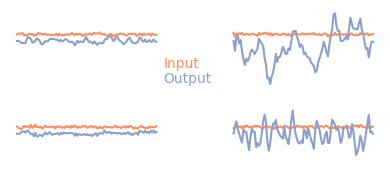

In [8]:
#plot examples of the inputs and the outputs
fig, ax = plt.subplots(2,2,figsize=(4,2),sharex=True,sharey=True)
ax = ax.flatten()
for i in range(4):
    ind = 4*i
    ax[i].plot(Us[ind].T[:100] + 10*np.mean(np.abs(Us[ind])), color=plt.cm.Set2(1), label='Input (u)')
    ax[i].plot(Ys[ind].T[:100, 0], color=plt.cm.Set2(2), label='Output (y)')
    #remove all ticks and lines
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    
ax[0].text(1, 0.4, 'Input', transform=ax[0].transAxes, color=plt.cm.Set2(1), va='top')
ax[0].text(1, 0.2, 'Output', transform=ax[0].transAxes, color=plt.cm.Set2(2), va='top')
plt.tight_layout()
# plt.savefig(f'{folder_path}/input_output_examples.pdf', format='pdf', dpi=300, bbox_inches='tight')



/var/folders/sh/r0d61tjn42s4mc3nxqb0hhq00000gn/T/ipykernel_79424/1787994131.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(title="Delays", loc='upper right', bbox_to_anchor=(1.5, 1),


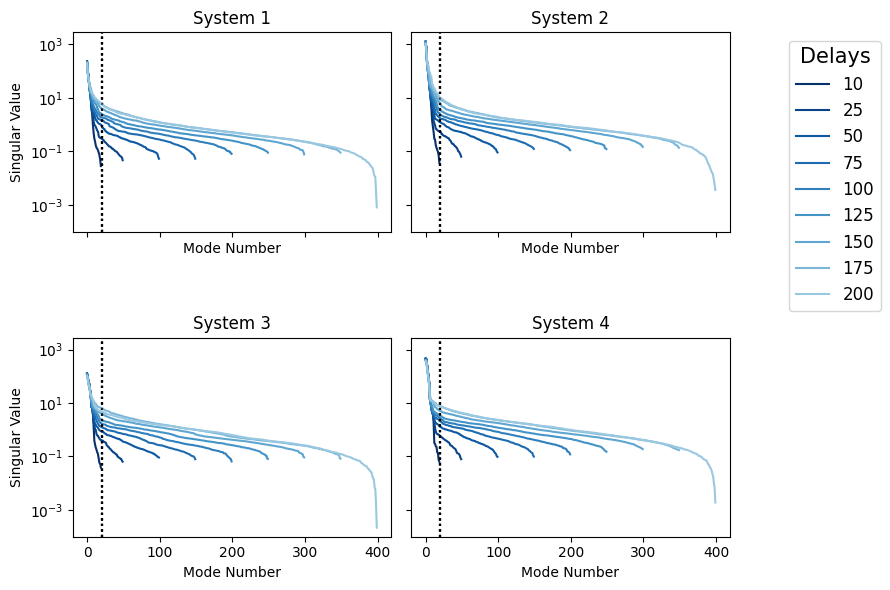

In [9]:
# Use SubspaceDMDc from DSA package to analyze singular values


fig, ax = plt.subplots(2,2,figsize=(9,6),sharey=True,sharex=True)
ax = ax.flatten()
            
for j, (Y, U) in enumerate(zip(Ys[::n_Us], Us[::n_Us])):
    # Test different numbers of delays for subspace identification
    nds_all = [10, 25, 50, 75, 100, 125, 150, 175, 200]
    for k, nds in enumerate(nds_all):
        # Fit SubspaceDMDc with varying number of delays
        model = SubspaceDMDc(
            Y.T,  # SubspaceDMDc expects (T, p_out)
            U.T,  # SubspaceDMDc expects (T, m)
            n_delays=nds,
            rank=rank,  # Use fixed rank for comparison
            backend='n4sid'
        )
        model.fit()
        
        # Extract singular values from model info
        singular_vals = model.info['singular_values_O']
        
        # Convert to numpy if needed
        if hasattr(singular_vals, 'numpy'):
            singular_vals = singular_vals.numpy()
        
        # Plot singular values
        ax[j].plot(singular_vals, '-', label=f'{nds}', 
                  color=plt.cm.Blues_r(k / (len(nds_all) + 4)))
        ax[j].set_yscale('log')
        ax[j].axvline(x=rank, color='k', linestyle=':', alpha=0.5)
    
    ax[j].set_xlabel('Mode Number')
    ax[j].set_title(f'System {j+1}')
    ax[1].legend(title="Delays", loc='upper right', bbox_to_anchor=(1.5, 1), 
                fontsize=12, title_fontsize=15)

ax[0].set_ylabel('Singular Value')
ax[2].set_ylabel('Singular Value')
plt.tight_layout()
# plt.savefig(f'{folder_path}/singular_values_subspace_dmdc.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [10]:
dec = 0 #can change this to look at the efect of using the incorrect ranks
A_dmd = get_dmds(Ys,n_delays=n_delays,rank=rank- dec)
A_cs, B_cs = get_dmdcs(Ys,Us,n_delays=n_delays,rank=rank - dec)
As, Bs, Cs, infos = get_subspace_dmdcs(Ys,Us,p=pf,rank=rank-dec,backend='custom')


N4SID - A matrix shapes: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
N4SID - Ranks used: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
N4SID - Backend info: ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
\nEigenvalue comparison (first system):


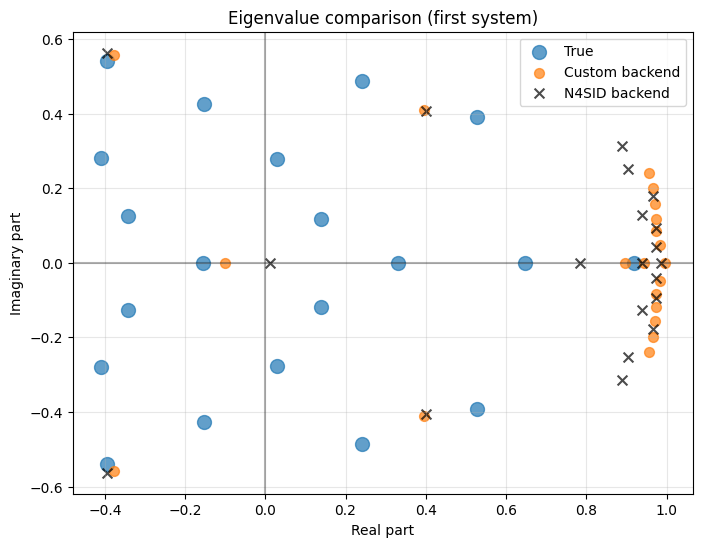

\nComputing similarity matrices...


100%|██████████| 16/16 [00:00<00:00, 220.96it/s]


Custom backend silhouette score: 0.980
N4SID backend silhouette score: 0.963


In [11]:
As_n4sid, Bs_n4sid, Cs_n4sid, infos_n4sid = get_subspace_dmdcs(Ys, Us, p=pf, rank=rank-dec, backend='n4sid')
print(f"N4SID - A matrix shapes: {[A.shape for A in As_n4sid]}")
print(f"N4SID - Ranks used: {[info['rank_used'] for info in infos_n4sid]}")
print(f"N4SID - Backend info: {[info.get('backend', 'unknown') for info in infos_n4sid]}")

# Quick comparison of eigenvalues (first system)
print("\\nEigenvalue comparison (first system):")
eigs_custom = np.linalg.eigvals(As[0])
eigs_n4sid = np.linalg.eigvals(As_n4sid[0])
eigs_real = np.linalg.eigvals(A_trues[0])

plt.figure(figsize=(8, 6))
plt.scatter(eigs_real.real, eigs_real.imag, alpha=0.7, label='True', s=100)
plt.scatter(eigs_custom.real, eigs_custom.imag, alpha=0.7, label='Custom backend', s=50)
plt.scatter(eigs_n4sid.real, eigs_n4sid.imag, alpha=0.7, label='N4SID backend', s=50, marker='x',c='k')
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalue comparison (first system)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.show()

# Compute distances using both backends for comparison
print("\\nComputing similarity matrices...")
_, _, _, _, sims_state_custom = compare_systems_full(As, Bs)
_, _, _, _, sims_state_n4sid = compare_systems_full(As_n4sid, Bs_n4sid)

from sklearn.metrics import silhouette_score
silh_custom = silhouette_score(sims_state_custom, state_labels, metric='precomputed')
silh_n4sid = silhouette_score(sims_state_n4sid, state_labels, metric='precomputed')


print(f"Custom backend silhouette score: {silh_custom:.3f}")
print(f"N4SID backend silhouette score: {silh_n4sid:.3f}")

100%|██████████| 16/16 [00:00<00:00, 227.44it/s]


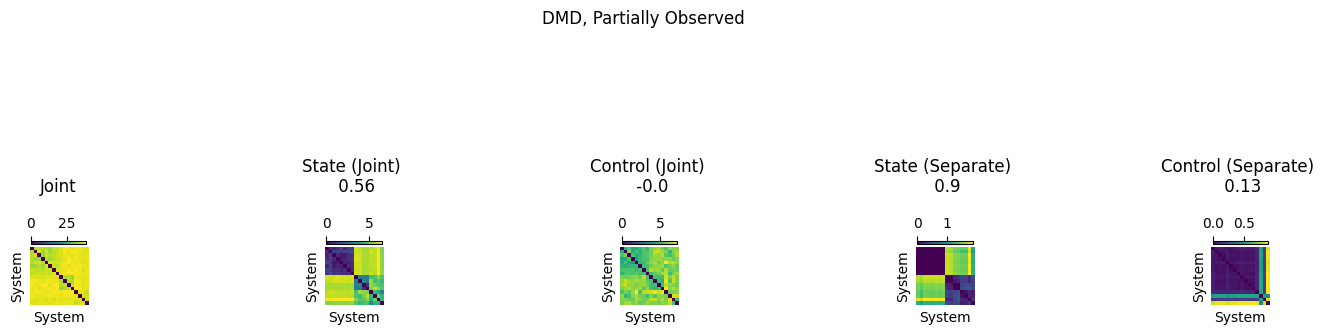

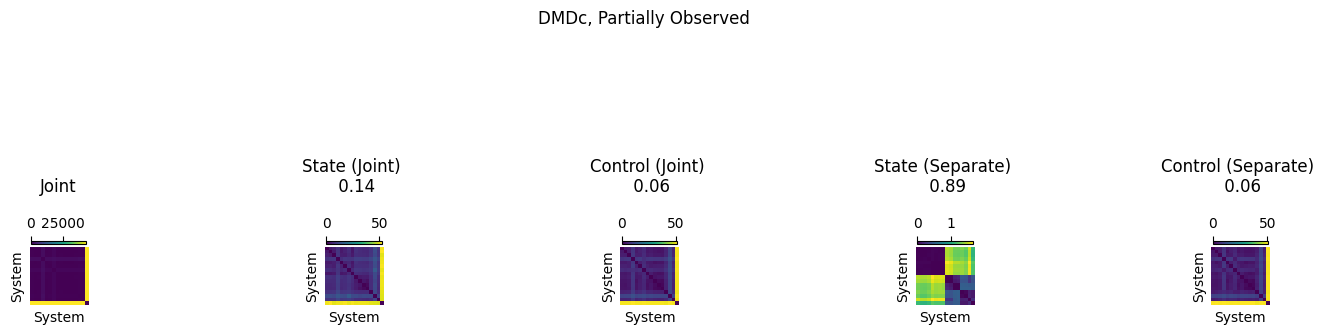

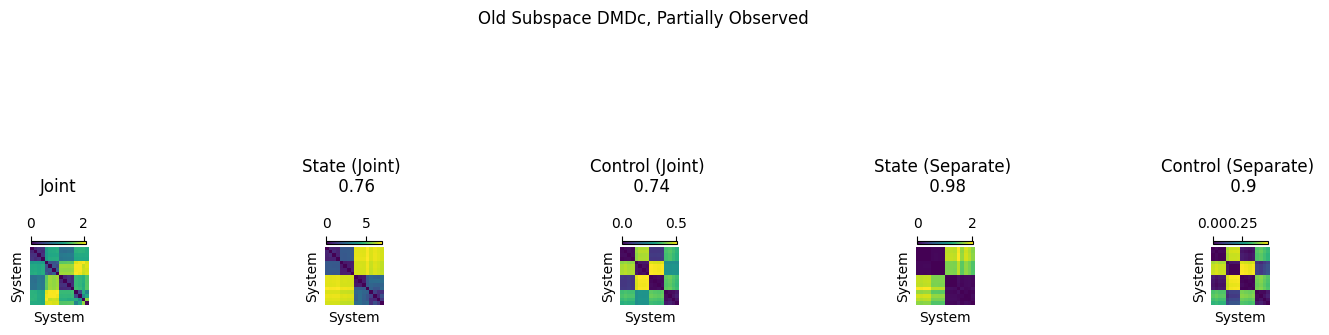

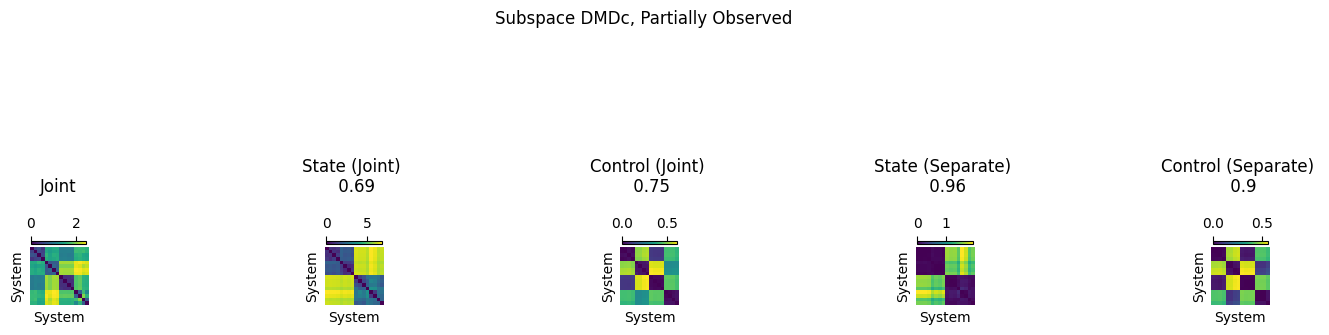

In [12]:
from sklearn.metrics import silhouette_score
A_type = [A_dmd, A_cs, As, As_n4sid]
B_type = [A_dmd, B_cs, Bs, Bs_n4sid]
names = ['DMD, Partially Observed', 'DMDc, Partially Observed', 'Old Subspace DMDc, Partially Observed', 'Subspace DMDc, Partially Observed']
for Ai, Bi, name in zip(A_type, B_type, names):

    sims_full, sims_control_joint, sims_state_joint, sims_control_separate, sims_state_separate = compare_systems_full(Ai,Bi)

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    
    # Define data and titles for each subplot
    sims_data = [sims_full, sims_state_joint, sims_control_joint, sims_state_separate, sims_control_separate]
    titles = ['Joint', 
              f'State (Joint) \n {np.round(silhouette_score(sims_state_joint,state_labels,metric="precomputed"),2)}',
              f'Control (Joint) \n {np.round(silhouette_score(sims_control_joint,control_labels,metric="precomputed"),2)}',
              f'State (Separate) \n {np.round(silhouette_score(sims_state_separate,state_labels,metric="precomputed"),2)}',
              f'Control (Separate) \n {np.round(silhouette_score(sims_control_separate,control_labels,metric="precomputed"),2)}']
    
    # Loop through all subplots
    for i, (data, title) in enumerate(zip(sims_data, titles)):
        im = ax[i].imshow(data)
        cbar = plt.colorbar(im, ax=ax[i], shrink=0.2, location='top')#, label='Distance')
        cbar.ax.tick_params(labelsize=10)
        cbar.ax.spines['top'].set_visible(False)
        cbar.ax.spines['right'].set_visible(False)
        cbar.ax.spines['bottom'].set_visible(False)
        cbar.ax.spines['left'].set_visible(False)
        ax[i].set_title(title,y=1.8)
    #loop through all of them and remove x and yticks, then add System as text label for each
    for i in range(5):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        # ax[i].text(0.5, -0.1, 'System', transform=ax[i].transAxes, ha='center', va='top')
        ax[i].set_ylabel('System')
        ax[i].set_xlabel('System')
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    plt.suptitle(name,y=1.1)
    plt.tight_layout()
    # plt.savefig(f'{folder_path}/{name}.eps', format='eps', dpi=300, bbox_inches='tight')


100%|██████████| 16/16 [00:00<00:00, 132.72it/s]


Silhouette Scores:
DMD State: 0.901
DMDc State: 0.887
DMDc Control: 0.064
SubspaceDMDc State: 0.963
SubspaceDMDc Control: 0.746


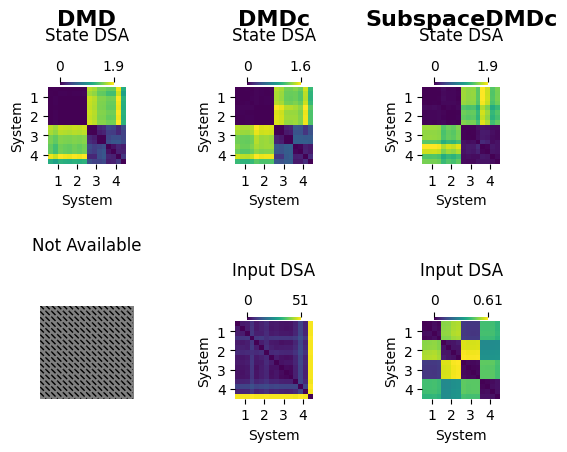

In [13]:
# Get the similarity matrices for each method
sims_full_dmd, sims_control_joint_dmd, sims_state_joint_dmd, sims_control_separate_dmd, sims_state_separate_dmd = compare_systems_full(A_dmd, A_dmd)
sims_full_dmdc, sims_control_joint_dmdc, sims_state_joint_dmdc, sims_control_separate_dmdc, sims_state_separate_dmdc = compare_systems_full(A_cs, B_cs)
sims_full_subdmdc, sims_control_joint_subdmdc, sims_state_joint_subdmdc, sims_control_separate_subdmdc, sims_state_separate_subdmdc = compare_systems_full(As_n4sid, Bs_n4sid)

# Print silhouette scores
print("Silhouette Scores:")
print(f"DMD State: {np.round(silhouette_score(sims_state_separate_dmd, state_labels, metric='precomputed'), 3)}")
print(f"DMDc State: {np.round(silhouette_score(sims_state_separate_dmdc, state_labels, metric='precomputed'), 3)}")
print(f"DMDc Control: {np.round(silhouette_score(sims_control_joint_dmdc, control_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc State: {np.round(silhouette_score(sims_state_separate_subdmdc, state_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc Control: {np.round(silhouette_score(sims_control_joint_subdmdc, control_labels, metric='precomputed'), 3)}")

# Create 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(6, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Column headers (bold)
column_headers = ['DMD', 'DMDc', 'SubspaceDMDc']
for i, header in enumerate(column_headers):
    axes[0, i].text(0.5, 1.75, header, transform=axes[0, i].transAxes, ha='center', va='bottom', fontweight='bold', fontsize=16)

# Row headers
row_headers = ['State DSA', ['Not Available', 'Input DSA', 'Input DSA']]
for i in range(3):
    axes[0, i].text(0.5, 1.55, 'State DSA', transform=axes[0, i].transAxes, ha='center', va='bottom', fontsize=12)

axes[1, 0].text(0.5, 1.55, 'Not Available', transform=axes[1, 0].transAxes, ha='center', va='bottom', fontsize=12)
axes[1, 1].text(0.5, 1.55, 'Input DSA', transform=axes[1, 1].transAxes, ha='center', va='bottom', fontsize=12)
axes[1, 2].text(0.5, 1.55, 'Input DSA', transform=axes[1, 2].transAxes, ha='center', va='bottom', fontsize=12)

# Data for each subplot
data_matrices = [
    sims_state_separate_dmd,    # top left
    sims_state_separate_dmdc,   # top middle  
    sims_state_separate_subdmdc, # top right
    None,                       # bottom left (gray matrix)
    sims_control_joint_dmdc,    # bottom middle
    sims_control_joint_subdmdc  # bottom right
]

# Create gray matrix for bottom left - use same size as other matrices
matrix_size = sims_state_separate_dmd.shape[0]
gray_matrix = np.ones((matrix_size, matrix_size)) * 0.5

# Plot each subplot
for idx, (ax, data) in enumerate(zip(axes.flat, data_matrices)):
    row = idx // 3
    col = idx % 3
    
    if idx == 3:  # Bottom left - gray matrix with diagonal lines
        im = ax.imshow(gray_matrix, cmap='gray', vmin=0, vmax=1, extent=[-0.5, matrix_size-0.5, matrix_size-0.5, -0.5])
        
        # Add diagonal lines from bottom-left to top-right
        for i in range(matrix_size):
            for j in range(matrix_size):
                ax.plot([j-0.5, j+0.5], [i-0.5, i+0.5], 'k--', linewidth=1)
        
        # Set axis limits to match other plots
        ax.set_xlim(-0.5, matrix_size-0.5)
        ax.set_ylim(matrix_size-0.5, -0.5)
        
        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # Remove spines
        for spine in ax.spines.values():
            spine.set_visible(False)
        
    else:
        im = ax.imshow(data, cmap='viridis')
        
        # Add colorbar on top with only 2 ticks
        cbar = plt.colorbar(im, ax=ax, shrink=0.4, location='top', pad=0.02)
        vmin, vmax = data.min(), data.max()
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([f'{vmin:.2g}', f'{vmax:.2g}'])
        cbar.ax.tick_params(labelsize=10)
        
        # Remove colorbar spines
        for spine in cbar.ax.spines.values():
            spine.set_visible(False)
        
        # Set custom tick positions and labels (every 4 positions)
        tick_positions = [1.5, 5.5, 9.5, 13.5]  # Middle of each group of 4
        tick_labels = ['1', '2', '3', '4']
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels,fontsize=10)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels,fontsize=10)
        
        # Set axis labels
        ax.set_xlabel('System',fontsize=10)
        ax.set_ylabel('System',fontsize=10)
        
        # Remove spines
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()


100%|██████████| 16/16 [00:00<00:00, 197.54it/s]


Silhouette Scores:
DMDc Full (state): 0.037
SubspaceDMDc Full (state): 0.293
DMDc Full (control): 0.051
SubspaceDMDc Full (control): 0.251


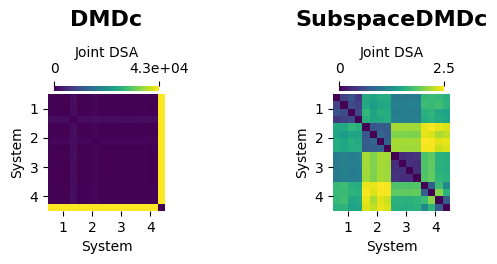

In [14]:
# Get the similarity matrices for each method
sims_full_dmdc, _, _, _, _ = compare_systems_full(A_cs, B_cs)
sims_full_subdmdc, _, _, _, _ = compare_systems_full(As_n4sid, Bs_n4sid)

# Print silhouette scores
print("Silhouette Scores:")
print(f"DMDc Full (state): {np.round(silhouette_score(sims_full_dmdc, state_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc Full (state): {np.round(silhouette_score(sims_full_subdmdc, state_labels, metric='precomputed'), 3)}")
print(f"DMDc Full (control): {np.round(silhouette_score(sims_full_dmdc, control_labels, metric='precomputed'), 3)}")
print(f"SubspaceDMDc Full (control): {np.round(silhouette_score(sims_full_subdmdc, control_labels, metric='precomputed'), 3)}")

# Create 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Column headers (bold)
column_headers = ['DMDc', 'SubspaceDMDc']
for i, header in enumerate(column_headers):
    axes[i].text(0.5, 1.55, header, transform=axes[i].transAxes, ha='center', va='bottom', fontweight='bold', fontsize=16)

# Data for each subplot
data_matrices = [
    sims_full_dmdc,    # left
    sims_full_subdmdc  # right
]

# Plot each subplot
for idx, (ax, data) in enumerate(zip(axes.flat, data_matrices)):
    im = ax.imshow(data, cmap='viridis')
    
    # Add colorbar on top with only 2 ticks
    cbar = plt.colorbar(im, ax=ax, shrink=0.4, location='top', pad=0.02,label='Joint DSA')
    vmin, vmax = data.min(), data.max()
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([f'{vmin:.2g}', f'{vmax:.2g}'])
    cbar.ax.tick_params(labelsize=10)
    
    # Remove colorbar spines
    for spine in cbar.ax.spines.values():
        spine.set_visible(False)
    
    # Set custom tick positions and labels (every 4 positions)
    tick_positions = [1.5, 5.5, 9.5, 13.5]  # Middle of each group of 4
    tick_labels = ['1', '2', '3', '4']
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, fontsize=10)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels, fontsize=10)
    
    # Set axis labels
    ax.set_xlabel('System', fontsize=10)
    ax.set_ylabel('System', fontsize=10)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()


In [15]:
#collect statistics now: 
#sample random systems from the set of 4 pairings
#sample 4 input drives for each system, making 16 diferent systems in total 
#compute silhouette score based on A labels and B labels

def get_silhouette_scores(n,m,p_out,N,n_iters,
    input_alpha=input_alpha,g1=g1,g2=g2,same_inp=False,n_Us=n_Us,
    n_delays=n_delays,pf=pf,rank=rank,process_noise=process_noise,obs_noise=obs_noise,
    nonlinear_eps=nonlinear_eps,nonlinear_func=lambda x: np.tanh(x),
    y_feature_map = lambda x: x, u_feature_map = lambda x: x,backend=backend,
    use_joint_control=True):

    silhouette_state_dmdc = []
    silhouette_control_dmdc = []

    silhouette_state_subspace_dmdc = []
    silhouette_control_subspace_dmdc = []

    silhouette_state_dsa = []
    silhouette_control_dsa = []


    for i in tqdm(range(n_iters)):
        X_trues, Ys, Us, control_labels, state_labels, *_ = simulate_As_Bs(n,m,p_out,
            N,input_alpha=input_alpha,g1=g1,g2=g2,same_inp=same_inp,n_Us=n_Us, seed1=seed1+i,seed2=seed2+110*i,
            obs_noise=obs_noise,process_noise=process_noise,
            nonlinear_eps=nonlinear_eps,nonlinear_func=nonlinear_func)
        Ys = list(map(y_feature_map, Ys))
        Us = list(map(u_feature_map, Us))

        A_cs, B_cs = get_dmdcs(Ys,Us,n_delays=n_delays,rank=rank)
        print('dmdc:', [i.shape for i in A_cs])
        As, Bs, Cs, infos = get_subspace_dmdcs(Ys,Us,p=pf,rank=rank,backend=backend)
        print('subspacedmdc:', [i.shape for i in As])
        A_dmds = get_dmds(Ys,n_delays=n_delays,rank=rank)
        print('dmd:', [i.shape for i in A_dmds])
        sims_full_dmdc, sims_control_joint_dmdc, sims_state_joint_dmdc, sims_control_separate_dmdc, sims_state_separate_dmdc = compare_systems_full(A_cs,B_cs)
        sims_full_subspace_dmdc, sims_control_joint_subspace_dmdc, sims_state_joint_subspace_dmdc, sims_control_separate_subspace_dmdc, sims_state_separate_subspace_dmdc = compare_systems_full(As,Bs)

        sims_state_dmd = compare_A_full(A_dmds)

        #compute silhouette scores
        silhouette_state_dmdc.append(silhouette_score(sims_state_separate_dmdc,state_labels,metric='precomputed'))
        if use_joint_control:
            silhouette_control_dmdc.append(silhouette_score(sims_control_joint_dmdc,control_labels,metric='precomputed'))
            silhouette_control_subspace_dmdc.append(silhouette_score(sims_control_joint_subspace_dmdc,control_labels,metric='precomputed'))
        else:
            silhouette_control_dmdc.append(silhouette_score(sims_control_separate_dmdc,control_labels,metric='precomputed'))
            silhouette_control_subspace_dmdc.append(silhouette_score(sims_control_separate_subspace_dmdc,control_labels,metric='precomputed'))
            
        silhouette_state_subspace_dmdc.append(silhouette_score(sims_state_separate_subspace_dmdc,state_labels,metric='precomputed'))

        silhouette_state_dsa.append(silhouette_score(sims_state_dmd,state_labels,metric='precomputed'))
        silhouette_control_dsa.append(silhouette_score(sims_state_dmd,control_labels,metric='precomputed'))

        print(silhouette_state_subspace_dmdc[-1],silhouette_state_dmdc[-1])
        print(silhouette_control_subspace_dmdc[-1],silhouette_control_dmdc[-1])

        # print(silhouette_state_subspace_dmdc,silhouette_control_subspace_dmdc)
    return silhouette_state_dmdc, silhouette_control_dmdc, silhouette_state_subspace_dmdc, silhouette_control_subspace_dmdc, silhouette_state_dsa, silhouette_control_dsa



In [16]:
n_iters = 10
silh_state_dmdc, silh_ctrl_dmdc, silh_state_subdmdc, silh_ctrl_subsdmdc, silh_state_dsa, silh_ctrl_dsa = get_silhouette_scores(n,m,p_out_small,
                                                                                                                5*N_small,n_iters,input_alpha=input_alpha,g1=g1,
                                                                                                               g2=g2,same_inp=False,n_Us=n_Us,n_delays=n_delays,rank=rank,pf=pf,
                                                                                                              obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps,
                                                                                                              backend=backend)

  0%|          | 0/10 [00:00<?, ?it/s]

dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 10%|█         | 1/10 [00:34<05:07, 34.15s/it]

0.9691272825017969 0.8582303653068575
0.7565087127808146 0.03803439019336802
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 20%|██        | 2/10 [01:05<04:17, 32.22s/it]

0.9816171028048734 0.9408706396597346
0.6532221986198002 0.006820164804708317
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 30%|███       | 3/10 [01:35<03:38, 31.24s/it]

0.767232379488872 0.1512070928218711
0.6157521309022611 0.05175886713659955
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 40%|████      | 4/10 [02:08<03:12, 32.00s/it]

0.9657347175367499 0.5254964762925847
0.7118533916252097 0.025776671998498396
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 50%|█████     | 5/10 [02:42<02:44, 32.94s/it]

0.8258727811216732 0.3294846094560002
0.7872473963632638 0.01233664181020297
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 60%|██████    | 6/10 [03:16<02:12, 33.03s/it]

0.7837082615720358 0.15120174923027987
0.6133477597597732 0.04460637606641188
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 70%|███████   | 7/10 [03:48<01:38, 32.70s/it]

0.15213020884633638 0.28032833751779207
0.7017545866785109 0.022449185478241485
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 80%|████████  | 8/10 [04:19<01:04, 32.36s/it]

0.9528029359995827 0.4007283173715651
0.6260107540792517 -0.020536760559146522
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 90%|█████████ | 9/10 [04:50<00:31, 31.79s/it]

0.5497244328142894 0.30866882882957425
0.7893131703514245 0.04832453849166829
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


100%|██████████| 10/10 [05:21<00:00, 32.13s/it]


0.7319381371318918 0.03569785229639352
0.860447067466593 0.022725976669829284


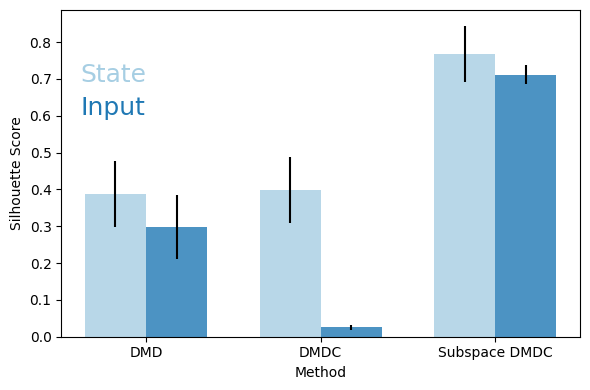

In [17]:
methods = [ 'DMD','DMDC', 'Subspace DMDC']
state_means = [np.mean(silh_state_dsa),np.mean(silh_state_dmdc), np.mean(silh_state_subdmdc)]
state_stds = [np.std(silh_state_dsa) / np.sqrt(n_iters), np.std(silh_state_dmdc) / np.sqrt(n_iters), np.std(silh_state_subdmdc) / np.sqrt(n_iters)]
control_means = [np.mean(silh_ctrl_dsa),np.mean(silh_ctrl_dmdc), np.mean(silh_ctrl_subsdmdc)]
control_stds = [np.std(silh_ctrl_dsa) / np.sqrt(n_iters), np.std(silh_ctrl_dmdc) / np.sqrt(n_iters), np.std(silh_ctrl_subsdmdc) / np.sqrt(n_iters)]

# Create bar plot
x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
# Prepare data for violin plots
state_data = [silh_state_dsa, silh_state_dmdc, silh_state_subdmdc]
control_data = [silh_ctrl_dsa, silh_ctrl_dmdc, silh_ctrl_subsdmdc]

# Option to create either violin plots or bar plots
plot_type = 'bar'  # Change to 'bar' for bar plots

if plot_type == 'violin':
    # Create violin plots
    violin_parts1 = ax.violinplot(state_data, positions=x - width/2, widths=width, showmeans=True, showmedians=False)
    violin_parts2 = ax.violinplot(control_data, positions=x + width/2, widths=width, showmeans=True, showmedians=False)

    # Color the violin plots
    for pc in violin_parts1['bodies']:
        pc.set_facecolor(plt.cm.Paired(0))
        pc.set_alpha(0.8)
        
    for pc in violin_parts2['bodies']:
        pc.set_facecolor(plt.cm.Paired(1))
        pc.set_alpha(0.8)

    # Set the color for violin lines (edges) as well
    for key in ['cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans']:
        if key in violin_parts2:
            violin_parts2[key].set_color(plt.cm.Paired(1))
    # Create legend manually
    # ax.plot([], [], color=plt.cm.Paired(0), alpha=0.8, label='State')
    # ax.plot([], [], color=plt.cm.Paired(1), alpha=0.8, label='Control')

elif plot_type == 'bar':
    # Create bar plots
    ax.bar(x - width/2, state_means, width, yerr=state_stds, alpha=0.8,color=plt.cm.Paired(0))
    ax.bar(x + width/2, control_means, width, yerr=control_stds, alpha=0.8,color=plt.cm.Paired(1))


ax.text(0.1, 0.8, 'State', color=plt.cm.Paired(0), fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.text(0.1, 0.7, 'Input', color=plt.cm.Paired(1), fontsize=18, ha='center', va='center', transform=ax.transAxes)


# Add labels and formatting
ax.set_xlabel('Method')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(x)
ax.set_xticklabels(methods)
# ax.legend(loc='upper left')

plt.tight_layout()
# plt.show()

In [18]:
rs = np.arange(2,25,1)
n_iters = 2
silh_state_dmdcs = []
silh_ctrl_dmdcs = []
silh_state_subdmdcs = []
silh_ctrl_subsdmdcs = []
silh_state_dsas = []
silh_ctrl_dsas = []

for r in rs:
    silh_state_dmdc, silh_ctrl_dmdc, silh_state_subdmdc, silh_ctrl_subsdmdc, silh_state_dsa, silh_ctrl_dsa = get_silhouette_scores(n,m,p_out_small,
                                                                                                                N_small,n_iters,input_alpha=input_alpha,g1=g1,
                                                                                                                g2=g2,same_inp=False,n_Us=n_Us,n_delays=n_delays,rank=r,pf=pf,
                                                                                                              obs_noise=obs_noise,process_noise=process_noise,nonlinear_eps=nonlinear_eps,
                                                                                                              backend=backend)
    silh_state_dmdcs.append(silh_state_dmdc)
    silh_ctrl_dmdcs.append(silh_ctrl_dmdc)
    silh_state_subdmdcs.append(silh_state_subdmdc)
    silh_ctrl_subsdmdcs.append(silh_ctrl_subsdmdc)
    silh_state_dsas.append(silh_state_dsa)
    silh_ctrl_dsas.append(silh_ctrl_dsa)


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
subspacedmdc: [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
dmd: [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]


 50%|█████     | 1/2 [00:05<00:05,  5.09s/it]

0.9531408210695748 0.751644714397508
0.7464886400711467 0.12159508515977946
dmdc: [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
subspacedmdc: [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]
dmd: [(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)]


100%|██████████| 2/2 [00:10<00:00,  5.05s/it]


0.9358636316921758 0.9898328829154682
0.7172649293339985 0.07752292998850752


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
subspacedmdc: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
dmd: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]


 50%|█████     | 1/2 [00:04<00:04,  4.86s/it]

0.8745472829437568 0.8250370191204569
0.7200099972664604 0.11478322546537062
dmdc: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
subspacedmdc: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
dmd: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]


100%|██████████| 16/16 [00:00<00:00, 321.91it/s]

0.7981153202538783


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


 0.9891920983892378
0.6793114976518821 0.1491104199310368


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]
subspacedmdc: [(4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]
dmd: [(4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]


 50%|█████     | 1/2 [00:04<00:04,  4.73s/it]

0.8006335787582183 0.7748891187429943
0.7612576369597122 0.1912605656375802
dmdc: [(4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]
subspacedmdc: [(4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]
dmd: [(4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4)]


100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


0.8259525752136729 0.9874954157019269
0.6521520593450556 0.07308496700887002


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]
subspacedmdc: [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]
dmd: [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]


 50%|█████     | 1/2 [00:04<00:04,  4.83s/it]

0.7312395232803113 0.7983719441523986
0.7658815097885352 0.15983440309290503
dmdc: [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]
subspacedmdc: [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]
dmd: [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5)]


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


0.7257133126510311 0.9664609022104687
0.639872495928252 0.006430861597669257


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6)]
subspacedmdc: [(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6)]
dmd: [(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6)]


 50%|█████     | 1/2 [00:04<00:04,  4.81s/it]

0.7836277344963275 0.7916555217205798
0.757829727397525 0.1872022355481463
dmdc: [(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6)]
subspacedmdc: [(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6)]
dmd: [(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6)]


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


0.5445982150952556 0.9732187369296093
0.6430669069183226 0.008356570963989257


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)]
subspacedmdc: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)]
dmd: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)]


 50%|█████     | 1/2 [00:04<00:04,  4.82s/it]

0.8610492488494463 0.8367885872232375
0.7567093490844614 0.12109375240490969
dmdc: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)]
subspacedmdc: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)]
dmd: [(7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7)]


100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


0.6194114562273334 0.9702865811350498
0.6458357971128883 0.035206787769524295


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]
subspacedmdc: [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]
dmd: [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]


 50%|█████     | 1/2 [00:04<00:04,  5.00s/it]

0.8828967988777602 0.8444937232760863
0.7539226861848893 0.05843904778576672
dmdc: [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]
subspacedmdc: [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]
dmd: [(8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8)]


100%|██████████| 2/2 [00:10<00:00,  5.09s/it]


0.7154990239898047 0.9686347061531324
0.6436116169422382 0.025055205181217816


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]
subspacedmdc: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]
dmd: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]


 50%|█████     | 1/2 [00:04<00:04,  4.98s/it]

0.9128970348137619 0.8579432644088368
0.7542142224388916 0.1541992410395923
dmdc: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]
subspacedmdc: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]
dmd: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]


100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


0.8021271244184729 0.9628351247829836
0.6422384125402689 0.04762552166629769


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


100%|██████████| 16/16 [00:00<00:00, 295.53it/s]

0.9406435528845267


 50%|█████     | 1/2 [00:05<00:05,  5.17s/it]

 0.8534478731534778
0.7537620557629012 0.028205123266255377
dmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
subspacedmdc: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]
dmd: [(10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10)]


100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


0.8649797841261901 0.9577234009193044
0.6397380023776962 -0.026284979283893103


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11)]
subspacedmdc: [(11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11)]
dmd: [(11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11)]


 50%|█████     | 1/2 [00:04<00:04,  4.83s/it]

0.9500566028807026 0.8705500032529395
0.7522356204788497 0.06912449482788813
dmdc: [(11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11)]
subspacedmdc: [(11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11)]
dmd: [(11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11), (11, 11)]


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


0.8546906426664412 0.9587973067930184
0.6361216524683637 0.023868927244365457


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]
subspacedmdc: [(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]
dmd: [(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]


 50%|█████     | 1/2 [00:04<00:04,  4.90s/it]

0.9680151944271322 0.8772439094084834
0.7520958229741626 0.04291183156419753
dmdc: [(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]
subspacedmdc: [(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]
dmd: [(12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12), (12, 12)]


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


0.907581037721845 0.9641776468748168
0.6342468279535208 -0.02798375745123348


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13)]
subspacedmdc: [(13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13)]
dmd: [(13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13)]


 50%|█████     | 1/2 [00:04<00:04,  4.91s/it]

0.9697233133312119 0.8909617621437101
0.7513693110359362 0.10147691476947701
dmdc: [(13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13)]
subspacedmdc: [(13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13)]
dmd: [(13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13), (13, 13)]


100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


0.8356993897113918 0.9650813091493078
0.6326676014385092 0.06057712777980473


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]
subspacedmdc: [(14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]
dmd: [(14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]


 50%|█████     | 1/2 [00:04<00:04,  4.93s/it]

0.9658263419560189 0.8879114609135228
0.7487820327517978 0.05874178199515395
dmdc: [(14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]
subspacedmdc: [(14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]
dmd: [(14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]


100%|██████████| 2/2 [00:09<00:00,  4.88s/it]


0.8989130732184136 0.9676327300072964
0.6337607914475055 -0.010030793730397086


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15)]
subspacedmdc: [(15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15)]
dmd: [(15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15)]


 50%|█████     | 1/2 [00:05<00:05,  5.14s/it]

0.9618669760946522 0.8878013313276367
0.7495701714090112 0.1333125512924334
dmdc: [(15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15)]
subspacedmdc: [(15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15)]
dmd: [(15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15), (15, 15)]


100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


0.9142016352181082 0.9601590645258198
0.6315622667152985 0.061983083746177475


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16)]
subspacedmdc: [(16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16)]
dmd: [(16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16)]


 50%|█████     | 1/2 [00:04<00:04,  4.84s/it]

0.953262909921702 0.8879655566022152
0.748574101123773 0.0815957626601313
dmdc: [(16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16)]
subspacedmdc: [(16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16)]
dmd: [(16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16), (16, 16)]


100%|██████████| 2/2 [00:09<00:00,  4.94s/it]


0.9020340428339566 0.9465269064852366
0.6314406926624092 -0.002759707734516781


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17)]
subspacedmdc: [(17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17)]
dmd: [(17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17)]


 50%|█████     | 1/2 [00:04<00:04,  4.88s/it]

0.971853261841921 0.885198575743924
0.748367348594523 0.06569164979439021
dmdc: [(17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17)]
subspacedmdc: [(17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17)]
dmd: [(17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17), (17, 17)]


100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


0.9139374358001568 0.9459394527492089
0.6296836866963601 0.03688086533729029


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18)]
subspacedmdc: [(18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18)]
dmd: [(18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18)]


 50%|█████     | 1/2 [00:04<00:04,  4.86s/it]

0.9524378731389866 0.8828488862813867
0.7474470478293957 0.0750155231031836
dmdc: [(18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18)]
subspacedmdc: [(18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18)]
dmd: [(18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18), (18, 18)]


100%|██████████| 2/2 [00:09<00:00,  4.89s/it]


0.9137941908361018 0.930338122405584
0.6301716317211821 0.014117342103063063


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]
subspacedmdc: [(19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]
dmd: [(19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]


 50%|█████     | 1/2 [00:04<00:04,  4.81s/it]

0.9579200163534667 0.8810645336112748
0.7459380519255265 0.05181165752834982
dmdc: [(19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]
subspacedmdc: [(19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]
dmd: [(19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19), (19, 19)]


100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


0.9165513994898294 0.9285636242726061
0.6300675516361913 0.007851719246144362


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


 50%|█████     | 1/2 [00:09<00:09,  9.90s/it]

0.9541745267802484 0.8866495732092784
0.7472058707110373 0.06517074819626739
dmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
subspacedmdc: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]
dmd: [(20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 20)]


100%|██████████| 2/2 [00:17<00:00,  8.88s/it]


0.9208313923686876 0.9226527349872471
0.6286577006136242 -0.01709332926439555


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21)]
subspacedmdc: [(21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21)]
dmd: [(21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21)]


 50%|█████     | 1/2 [00:19<00:19, 19.34s/it]

0.9611425448723863 0.8957441277429837
0.7457115657908041 0.05984199310147731
dmdc: [(21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21)]
subspacedmdc: [(21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21)]
dmd: [(21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21), (21, 21)]


100%|██████████| 2/2 [00:26<00:00, 13.31s/it]


0.9260369370450757 0.9151553231502526
0.6295512806610911 -0.0015256924894253288


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22)]
subspacedmdc: [(22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22)]
dmd: [(22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22)]


 50%|█████     | 1/2 [00:07<00:07,  7.04s/it]

0.9621496235334114 0.9003190536716277
0.7462753634875992 0.04347795871798134
dmdc: [(22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22)]
subspacedmdc: [(22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22)]
dmd: [(22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22), (22, 22)]


100%|██████████| 2/2 [00:20<00:00, 10.46s/it]


0.9334854821394902 0.9014783456091258
0.6286412912077394 -0.025129602117762488


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23)]
subspacedmdc: [(23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23)]
dmd: [(23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23)]


 50%|█████     | 1/2 [00:16<00:16, 16.16s/it]

0.957875392307344 0.8935756915347725
0.7452794073343041 0.013108771938180747
dmdc: [(23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23)]
subspacedmdc: [(23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23)]
dmd: [(23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23), (23, 23)]


100%|██████████| 2/2 [00:24<00:00, 12.09s/it]


0.9265469457308625 0.8897109771785252
0.6312769105122846 0.024814422636565775


  0%|          | 0/2 [00:00<?, ?it/s]

dmdc: [(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]
subspacedmdc: [(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]
dmd: [(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]


 50%|█████     | 1/2 [00:07<00:07,  7.09s/it]

0.9579148132673488 0.8937497658792151
0.7454332785802394 0.05010980054836753
dmdc: [(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]
subspacedmdc: [(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]
dmd: [(24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24), (24, 24)]


100%|██████████| 2/2 [00:13<00:00,  6.89s/it]

0.9228377313102021 0.8891951391322248
0.6318162920324164 -0.008518802270398834


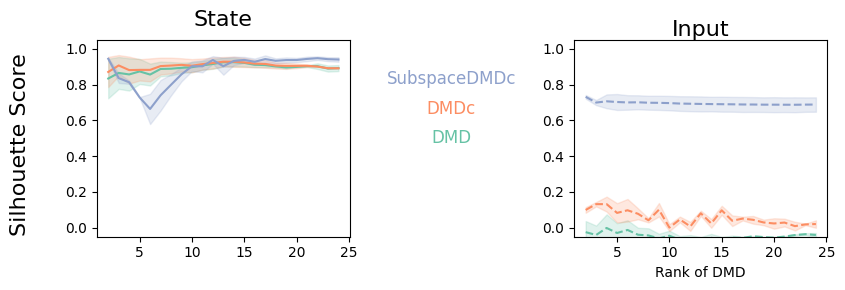

In [19]:
methods = ['DMD','DMDc','Subspace DMDc']
#on two plots, plot the mean and std of the silhouette scores for each method across p_out / n

fig, ax = plt.subplots(1,2, figsize=(8,3),sharex=True)

# Plot state silhouette scores

for i, state in enumerate([silh_state_dsas,silh_state_dmdcs,silh_state_subdmdcs]):
    ax[0].plot(rs, np.mean(state, axis=1), label=methods[i] + ' (State)',color=plt.cm.Set2(i))
    ax[0].fill_between(rs, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

for i, state in enumerate([silh_ctrl_dsas,silh_ctrl_dmdcs,silh_ctrl_subsdmdcs]):
    ax[1].plot(rs, np.mean(state, axis=1), label=methods[i] + ' (Control)',color=plt.cm.Set2(i),linestyle='--')
    ax[1].fill_between(rs, np.mean(state, axis=1) - np.std(state, axis=1) / np.sqrt(n_iters),
                       np.mean(state, axis=1) + np.std(state, axis=1) / np.sqrt(n_iters), alpha=0.2,
                       color=plt.cm.Set2(i))

# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
ax[0].set_ylim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
# Create custom legend with colored text
from matplotlib.lines import Line2D
ax[0].text(1.4, 0.8, 'SubspaceDMDc', color=plt.cm.Set2(2), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)
ax[0].text(1.4, 0.65, 'DMDc', color=plt.cm.Set2(1), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)
ax[0].text(1.4, 0.5, 'DMD', color=plt.cm.Set2(0), fontsize=12, ha='center', va='center', transform=ax[0].transAxes)

# Add subplot titles
ax[0].set_title('State', fontsize=16, pad=10)
ax[1].set_title('Input', fontsize=16, pad=3)
ax[1].set_xlabel('Rank of DMD')
fig.text(-0.05, 0.5, 'Silhouette Score', va='center', rotation='vertical',fontsize=16)
plt.tight_layout()
